根據使用者的篩選條件:  
貓星人(寵物)
pet

---

11公路: 標準 : 步行15分鐘內  
201 1000  
202 1000  
203 1000  
204 1000  

---

吃貨  
101 300  
102 2100  

---

4運動達人  
402 1300  
403 1400  

---

5購物文青  
301 2400  
302 1200  
303 4800  
304 4100  
305 2200  

---

6安居  
501  4000  
502  5800  
504  6000  
505  6000  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)

import json
import numpy as np
import pandas as pd

from sklearn.neighbors import KernelDensity
from sklearn.neighbors import KDTree
#latlng => TWD97
from LatLonToTWD97 import LatLonToTWD97
c = LatLonToTWD97()

with open('./data/typeid.json') as f:
    typeid = json.load(f)
with open('./data/bw_result.json') as f:
    typebw = json.load(f)
rentdf = pd.read_csv('./data/clear_rent_items.csv')
envdf = pd.read_csv('./data/clear_env_items.csv')

In [3]:
typeid

{'101': 'Food',
 '102': 'Supermarket',
 '201': 'Bus',
 '202': 'MRT',
 '203': 'UBike',
 '204': 'Train',
 '205': 'Exam',
 '206': 'Charger',
 '207': 'Towing',
 '301': 'BookStore',
 '302': 'DepartmentStore',
 '303': 'Library',
 '304': 'Museum',
 '305': 'Theater',
 '401': 'Park',
 '402': 'Scenic',
 '403': 'Sport',
 '501': 'School',
 '502': 'Hospital',
 '503': 'Pharmacy',
 '504': 'Police',
 '505': 'FireStation'}

In [4]:
%%time
#用KDE計算各類別分數
rentdata = list(map(c.convert,rentdf.loc[:,['lat','lng']].values))
col = '{}:{}'
kdtree = {}
kdedf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    data = list(map(c.convert,envdf[envdf.typeID==int(key)].loc[:,['lat','lng']].values))
    kdtree[key] = KDTree(data)
    kde = KernelDensity(bandwidth=bw)
    kde.fit(data)
    kdedf[name] = kde.score_samples(rentdata)

CPU times: user 1min 3s, sys: 33.1 ms, total: 1min 3s
Wall time: 1min 3s


In [5]:
expkdedf = kdedf.apply(np.exp)

In [6]:
expkdedf.columns

Index(['101:Food', '102:Supermarket', '201:Bus', '202:MRT', '203:UBike',
       '204:Train', '205:Exam', '206:Charger', '207:Towing', '301:BookStore',
       '302:DepartmentStore', '303:Library', '304:Museum', '305:Theater',
       '401:Park', '402:Scenic', '403:Sport', '501:School', '502:Hospital',
       '503:Pharmacy', '504:Police', '505:FireStation'],
      dtype='object')

In [7]:
%%time
#使用bandwidth當作半徑計算個數
col = '{}:{}'
countdf = pd.DataFrame()
for key, value in typeid.items():
    name = col.format(key,typeid[key])
    bw = int(typebw[key])
    countdf[name] = kdtree[key].query_radius(rentdata,r=bw, count_only=True)

CPU times: user 1.1 s, sys: 1.98 ms, total: 1.1 s
Wall time: 1.11 s


In [346]:
kdtree['502'].query_radius([(294397.3348892754, 2785990.99944911)],r=10000)

array([array([55, 56, 61, 35, 36, 58, 59, 60, 54, 39, 11, 33])], dtype=object)

In [8]:
from sklearn.preprocessing import LabelEncoder
#pet
le = LabelEncoder()
le.fit(rentdf.pet)

LabelEncoder()

In [9]:
le.classes_

array(['N', 'Y'], dtype=object)

In [10]:
tagdf = pd.DataFrame()

In [11]:
tagdf['tag:pet'] = le.transform(rentdf.pet)

In [12]:
#convienence transport
trans = {'201':800,'202':800,'203':800}
col = '{}:{}'
trans_df = pd.DataFrame()
for key, value in trans.items():
    name = col.format(key,typeid[key])
    bw = value
    trans_df[name] = kdtree[key].query_radius(rentdata,r=bw, count_only=True)

In [13]:
rentdf['transport'] = (trans_df>0).T.sum()

In [14]:
rentdf.groupby('transport').count().ID

transport
0      193
1      887
2     6343
3    13325
Name: ID, dtype: int64

In [84]:
trans = expkdedf.iloc[:,2:5].T.sum().T

In [87]:
trans.describe()

count    2.074800e+04
mean     8.438625e-09
std      4.736872e-09
min      2.123348e-19
25%      4.914716e-09
50%      8.548278e-09
75%      1.278381e-08
max      1.639613e-08
dtype: float64

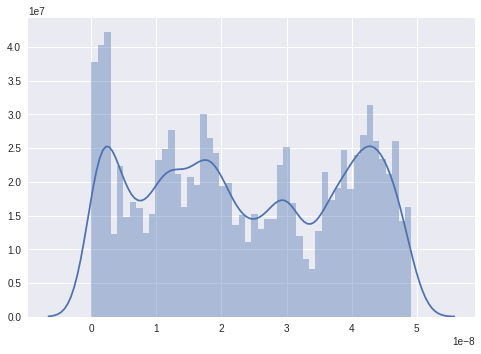

In [89]:
sns.distplot(trans*rentdf.transport, bins=50)

In [126]:
transport = pd.Series(trans*rentdf.transport)

In [127]:
#交通便利
tagdf['tag:transport'] = transport

In [134]:
#小資
tagdf['tag:capital'] = rentdf.rent<rentdf.rent.quantile(0.25)

In [129]:
#家庭
tagdf['tag:home'] = rentdf.label == '住'

In [94]:
#4運動達人
tmpdf = expkdedf.loc[:,['402:Scenic','403:Sport']]

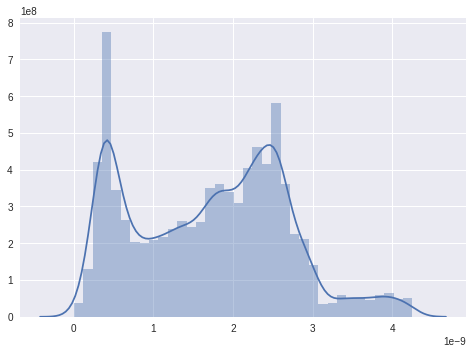

In [95]:
sns.distplot(tmpdf.T.mean().T)

In [96]:
sport = tmpdf.T.mean().T

In [97]:
sport.describe()

count    2.074800e+04
mean     1.711459e-09
std      9.700659e-10
min      4.211763e-27
25%      7.836896e-10
50%      1.805521e-09
75%      2.450175e-09
max      4.250438e-09
dtype: float64

In [130]:
tagdf['tag:sport'] = sport

(count    2.074800e+04
 mean     3.383976e-09
 std      2.610360e-09
 min      8.481889e-14
 25%      1.208352e-09
 50%      2.551371e-09
 75%      5.596105e-09
 max      8.895233e-09
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x7f69e4144588>)

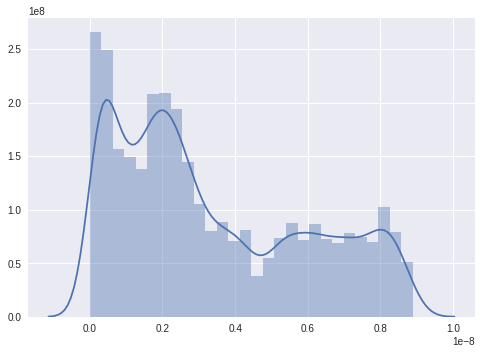

In [99]:
#文青 '301:BookStore','302:DepartmentStore', '303:Library', '304:Museum', '305:Theater'
culture = expkdedf.iloc[:,9:14].T.mean().T
culture.describe(),sns.distplot(culture)

In [131]:
tagdf['tag:culture'] = culture

(count    2.074800e+04
 mean     3.079522e-09
 std      1.756489e-09
 min      8.097153e-12
 25%      1.715940e-09
 50%      2.756701e-09
 75%      4.818277e-09
 max      5.865741e-09
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x7f69cb4c89b0>)

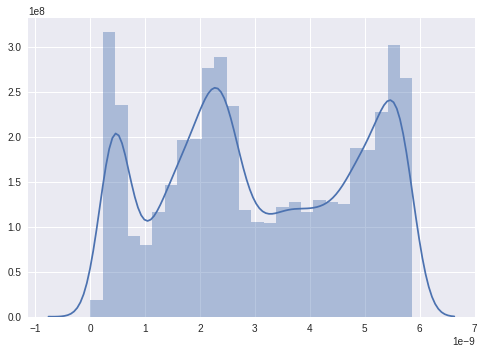

In [101]:
#safe 6安居 5xx
safe = expkdedf.iloc[:,17:23].T.max().T
safe.describe(), sns.distplot(safe)

In [132]:
tagdf['tag:safe'] = safe

(count    2.074800e+04
 mean     2.428423e-09
 std      1.493804e-09
 min      5.040060e-67
 25%      1.012774e-09
 50%      2.506566e-09
 75%      3.800593e-09
 max      4.896601e-09
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x7f69cabf2208>)

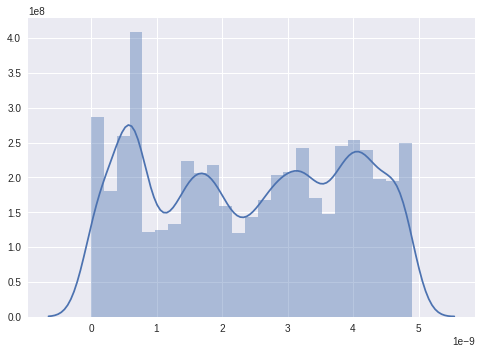

In [267]:
food = expkdedf.iloc[:,0:2].T.min().T
food.describe(), sns.distplot(food)

In [268]:
tagdf['tag:food'] = food

In [278]:
#compute avg cost of food
foodf = envdf[envdf.typeID==101]

def foodavg(array):
    if len(array)>0:
        return np.nanmean(foodf.loc[array,'cost'].dropna())
    else:
        return 0

favg = list(map(foodavg,kdtree['101'].query_radius(rentdata,r=typebw['101'])))

In [285]:
foodcost = pd.Series(favg)

In [284]:
foodcost

count    20748.000000
mean       201.817761
std        107.014719
min          0.000000
25%        134.948276
50%        184.030952
75%        253.056303
max       1200.000000
dtype: float64

(count    20748.000000
 mean       201.817761
 std        107.014719
 min          0.000000
 25%        134.948276
 50%        184.030952
 75%        253.056303
 max       1200.000000
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x7f69ca9c4320>)

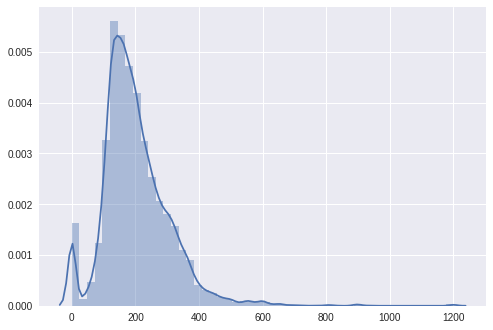

In [286]:
foodcost.describe(), sns.distplot(foodcost)

In [407]:
tagdf.head()

,tag:pet,tag:transport,tag:capital,tag:home,tag:sport,tag:culture,tag:safe,tag:food
0,0,2.308837e-09,False,True,2.371785e-09,2.985829e-10,4.055227e-10,6.525216e-10
1,0,4.929156e-10,False,True,4.867298e-10,1.577500e-10,2.695675e-10,1.674150e-13
2,0,2.016696e-09,False,True,1.510399e-09,3.114562e-10,4.757647e-10,5.635096e-10
3,0,3.944688e-09,True,False,2.889785e-09,3.421215e-10,4.645851e-10,6.550678e-10
4,0,0.000000e+00,True,False,3.119021e-10,1.185515e-10,2.360633e-10,3.504588e-11


In [383]:
tagdf.quantile()

tag:pet          0.000000e+00
tag:transport    2.195041e-08
tag:capital      0.000000e+00
tag:home         0.000000e+00
tag:sport        1.805521e-09
tag:culture      2.551371e-09
tag:safe         2.756701e-09
tag:food         2.506566e-09
Name: 0.5, dtype: float64

In [408]:
tagdf.apply(lambda x: (x - x.mean())/x.std() > 0).mean()

tag:pet          0.191778
tag:transport    0.475709
tag:capital      0.248602
tag:home         0.160979
tag:sport        0.531328
tag:culture      0.405678
tag:safe         0.463659
tag:food         0.512628
dtype: float64

In [288]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [610]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [602]:
from sklearn.preprocessing import robust_scale
test = robust_scale(tagdf)

In [641]:
test = pd.DataFrame(test)

In [642]:
test = pd.DataFrame(sc.fit_transform(tagdf.T).T)

In [643]:
test.columns=tagdf.columns
test.iloc[:,0:4] = test.iloc[:,0:4].apply(lambda x: (x - x.mean())/x.std() > 0.5)
test.iloc[:,4:8] = test.iloc[:,4:8].apply(lambda x: (x - x.mean())/x.std() > 0.5)

In [650]:
test.mean()

tag:pet          0.191778
tag:transport    0.590274
tag:capital      0.248602
tag:home         0.160979
tag:sport        0.418161
tag:culture      0.405726
tag:safe         0.506748
tag:food         0.481010
dtype: float64

In [651]:
test[test['tag:pet']].mean()

tag:pet          1.000000
tag:transport    0.377984
tag:capital      0.120131
tag:home         0.099020
tag:sport        0.384519
tag:culture      0.343302
tag:safe         0.396331
tag:food         0.400854
dtype: float64

In [652]:
test.T.sum().describe()

count    20748.000000
mean         3.003277
std          1.643327
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          8.000000
dtype: float64

In [634]:
pd.DataFrame(test.T.sum()<1).sum()

0    0
dtype: int64

In [647]:
test2.shape

(20748, 8)

In [609]:
test2 = test.copy()

In [648]:
test = test | test2

In [649]:
test.shape

(20748, 8)

In [635]:
rentdf['twd97'] = rentdata

In [636]:
rentdf['food:avgcost'] = foodcost

In [637]:
#rentdf.join(test).to_csv('./data/tag.csv', index=False)
rentdf.join(test).to_csv('./data/tag_003.csv', index=False)

In [638]:
checkdf = rentdf[test['tag:sport']]

In [639]:
checkdf.shape

(8676, 13)

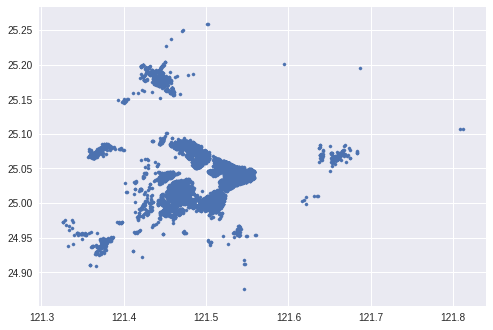

In [640]:
plt.scatter(checkdf['lng'],checkdf['lat'],s=10)

In [653]:
pd.read_csv('./data/tag_003.csv').shape

(20748, 21)